In [1]:
import traceback

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import finesse
import finesse.analysis as analysis
from finesse.enums import TraceType
from finesse.exceptions import FinesseException

finesse.plotting.init()

## Using Finesse 3 beam tracing via the analysis interface

In this notebook we will show how to interact with the beam tracing sub-module of Finesse 3 using the
corresponding analysis classes.

Whilst one can just as easily call the beam tracing related functions of a `Model` directly, it is recommended
to use them via their analysis interface as all error handling is performed here [TODO: add a link to a documentation
page here describing the principles of error handling in Finesse, and how external libraries should handle a
thrown `FinesseException`.]

There are currently three beam tracing analysis classes:

- `BeamTrace` --- this handles "simulation"-type beam traces, i.e. tracing the beam throughout the entirety of the model. It
                  returns a `SimulationTraceSolution` object which contains properties and methods to conveniently access and
                  display the beam parameters at any node / path of nodes in the model. A `BeamTrace` analysis class can be
                  created and executed, returning its solution object, with the `finesse.analysis.beam_trace` function.
- `UtilityTrace` --- takes care of "utility"-type beam traces, i.e. traces an arbitrary beam along some pre-defined path of the
                     model (it DOES NOT set beam parameters at nodes for a simulation). It will return a `UtilityTraceSolution`
                     object which has several methods for displaying the results and plotting the beam size and accumulated Gouy
                     phase along the path. A `UtilityTrace` analysis clas can be created and executed, returning its solution object,
                     with the `finesse.analysis.utility_trace` function.
- `ABCD` --- computes a composite ABCD matrix over some pre-defined path of the model. Currently this just returns a `np.ndarray` (or
             a two element tuple of for both planes) - [TODO: should this return some sort of `ABCDSolution` object which acts as
             a wrapper around the matrix / matrices?] An `ABCD` analysis can be created and executed, returning its solution object,
             with the `finesse.analysis.abcd` function.

### Running a `BeamTrace` analysis

The following example demonstrates how one can perform a `BeamTrace` analysis on an
arbitrary model.

In [2]:
model = finesse.Kat()
model.parse("""
### L0 -> BS -> YARM of ET-LF

l L0 P=1
s l0 L0.p1 BS.p1 L=9

# Main beam splitter at 60 deg input AOI
bs BS T=0.5 L=37.5u alpha=60
s BSsub1 BS.p3 BSAR1.p1 L=0.07478 nr=1.44963098985906
s BSsub2 BS.p4 BSAR2.p1 L=0.07478 nr=1.44963098985906
bs BSAR1 R=50u L=0 alpha=-36.6847
bs BSAR2 R=50u L=0 alpha=36.6847

# Y arm telescope
s lBS_ZM2 BS.p2 ZM2.p1 L=1
bs ZM2 T=250u L=37.5u
s lZM1_ZM2 ZM2.p2 ZM1.p1 L=13.1
bs ZM1 T=0 L=37.5u Rc=26.1
s lZM1_ITMlens ZM1.p2 ITM_lens.p1 L=52.3

lens ITM_lens inf
s lITM_th2 ITM_lens.p2 ITMAR.p1 L=0

# Y arm input mirror
m ITMAR R=0 L=20u
s ITMsub ITMAR.p2 ITM.p1 L=0.2 nr=1.44963098985906
m ITM T=7000u L=37.5u Rc=-5580

# Y arm length
s l_arm ITM.p2 ETM.p1 L=10k

# Y arm end mirror
m ETM T=6u L=37.5u Rc=5580
s ETMsub ETM.p2 ETMAR.p1 L=0.2 nr=1.44963098985906
m ETMAR R=0 L=500u


# cavities
cav cavARM ITM.p2.o ITM.p2.i


lambda 1550n
""")
ifo = model.model

In [3]:
trace_sol = analysis.beam_trace(ifo)
# print a sub-path of the model
telescope_path = ifo.path(ifo.ITM.p2.i, ifo.BS.p2.i)
trace_sol.print(path=telescope_path)

╒════════════════╤════════════════════════════════════════════╤══════════════════╤════════════════════╤════════════════════════════════════════════╤══════════════════╤════════════════════╕
│ Optical node   │ Beam parameter qx (tangential)             │   Beam size [cm] │   Gouy phase [deg] │ Beam parameter qy (sagittal)               │   Beam size [cm] │   Gouy phase [deg] │
╞════════════════╪════════════════════════════════════════════╪══════════════════╪════════════════════╪════════════════════════════════════════════╪══════════════════╪════════════════════╡
│ ITM.p2.i       │ (4999.999999999999+1702.9386365926407j)    │       8.9907     │            71.1918 │ (4999.999999999999+1702.9386365926407j)    │       8.9907     │            71.1918 │
├────────────────┼────────────────────────────────────────────┼──────────────────┼────────────────────┼────────────────────────────────────────────┼──────────────────┼────────────────────┤
│ ITM.p1.o       │ (5288.094506691626+1242.426591649232

One can pass `kwargs` to `finesse.analysis.beam_trace` corresponding to the arguments of `Model.beam_trace`. As an
example of this below, we use `store=False` to tell the beam tracing routine not to store the results of the trace
in the `last_trace` property of the `Model`. This means than any simulation performed thereafter would still use the
results of the prior beam trace.

In [4]:
ifo.ZM1.Rc = 50
# kwargs can be passed to beam_trace corresponding to the args of Model.beam_trace
# -> here we just tell the beam trace not to store the results in the last_trace property
#    of the Model (so that any simulation performed would still use the results of the
#    prior beam trace)
trace_sol_mod = analysis.beam_trace(ifo, store=False)
trace_sol_mod.print(path=telescope_path)

assert ifo.last_trace == trace_sol

ifo.ZM1.Rc = 26.1

╒════════════════╤════════════════════════════════════════════╤══════════════════╤════════════════════╤════════════════════════════════════════════╤══════════════════╤════════════════════╕
│ Optical node   │ Beam parameter qx (tangential)             │   Beam size [cm] │   Gouy phase [deg] │ Beam parameter qy (sagittal)               │   Beam size [cm] │   Gouy phase [deg] │
╞════════════════╪════════════════════════════════════════════╪══════════════════╪════════════════════╪════════════════════════════════════════════╪══════════════════╪════════════════════╡
│ ITM.p2.i       │ (4999.999999999999+1702.9386365926407j)    │          8.9907  │            71.1918 │ (4999.999999999999+1702.9386365926407j)    │          8.9907  │            71.1918 │
├────────────────┼────────────────────────────────────────────┼──────────────────┼────────────────────┼────────────────────────────────────────────┼──────────────────┼────────────────────┤
│ ITM.p1.o       │ (5288.094506691626+1242.426591649232

### Running a `UtilityTrace` analysis

Below we show how to execute a `UtilityTrace` analysis, using the same telescope model from above.

Similarly to the `finesse.analysis.beam_trace` function, we can also pass `kwargs` to the `finesse.analysis.utility_trace`
function. These `kwargs` must correspond to the arguments of `Model.utility_trace`.

Note that `q_in` is a positional argument to `utility_trace` and must be specified.

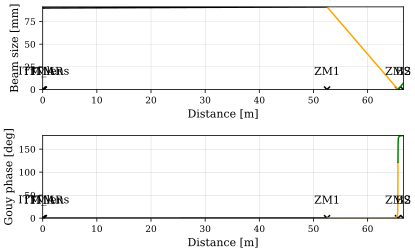

In [5]:
util_sol = analysis.utility_trace(ifo, q_in=ifo.cavARM.q.reverse(), path=telescope_path, direction='x')
util_sol.plot();

In [6]:
util_sol.print()

╒══════════╤═════════╤════════════╤════════════════════╤══════════════╤═══════════════════╤════════════════════════════════════════════╕
│ Name     │   z [m] │    w0 [mm] │   Beam radius [mm] │      RoC [m] │   Acc. Gouy [deg] │ q                                          │
╞══════════╪═════════╪════════════╪════════════════════╪══════════════╪═══════════════════╪════════════════════════════════════════════╡
│ ITM      │     0   │ 28.9861    │         89.907     │ 5580         │       0           │ (5288.094506691626+1242.426591649232j)     │
├──────────┼─────────┼────────────┼────────────────────┼──────────────┼───────────────────┼────────────────────────────────────────────┤
│ ITMAR    │     0.2 │ 20.5635    │         89.9102    │ 5580.19      │       0.000482475 │ (3648.0280455412853+857.0640392904587j)    │
├──────────┼─────────┼────────────┼────────────────────┼──────────────┼───────────────────┼────────────────────────────────────────────┤
│ ITM_lens │     0.2 │ 20.5635    │      

### Running an `ABCD` analysis

Performing an `ABCD` analysis is just as simple as the above examples, as shown below.

In [7]:
abcd_sol = analysis.abcd(ifo, path=telescope_path, direction='x')
print(abcd_sol.M)

q_in = finesse.gaussian.transform_beam_param(abcd_sol.M, ifo.cavARM.q.reverse())
q_BS = finesse.BeamParam(q=q_in, wavelength=ifo.lambda0)
print(f"Beam size at BS = {q_BS.w / 1e-3} mm")

[[-0.07966358  9.8808533 ]
 [-0.07687156 -3.01823495]]
Beam size at BS = 7.003319663226193 mm


In [8]:
abcd_sol_both = analysis.abcd(ifo, path=telescope_path)
print(abcd_sol_both.M)

(array([[-0.07966358,  9.8808533 ],
       [-0.07687156, -3.01823495]]), array([[-0.07966358,  9.8808533 ],
       [-0.07687156, -3.01823495]]))


### Handling errors from a beam trace analysis

Any type of analysis will raise a `FinesseException` if something goes wrong during a
call to the `_run()` method of the analysis class. Therefore, any external library which
uses Finesse can wrap the execution of an analysis in a `try-catch` block with `FinesseException`
as the exception type to be caught.

As an example of this below, we set the length of the arm cavity to 12 km (causing it to become unstable)
and try to perform a beam trace. This will now fail as there are no stable cavities nor manual beam parameters
set in the model.

From the printed traceback shown below, you can see that the full traceback is tacked onto the `FinesseException`
thrown from the analysis class - this helps to identify exactly where the issue is coming from.

In [9]:
ifo.elements['l_arm'].L = 12e3

try:
    trace_sol_long_arm = analysis.beam_trace(ifo)
except FinesseException as ex:
    print(ex)
    #traceback.print_exc()

AttributeError: 'Cavity' object has no attribute 'stability'

### Ideas / concerns

- Temporary modification of values would be very useful for analyses (especially when in notebook environments). Using the example
  from above, after modifying the length of the arm cavity this change is currently "permanent" and would result in, e.g., code cell
  3 failing due to no stable cavities. To solve this we could use some context manager associated with analyses, something like:

```python
import finesse
import finesse.analysis as analysis

model = finesse.parse("""...""")
ifo = model.model

with analysis.on(ifo) as ifo_a:
    # this should now be a temporary change which does not affect ifo itself
    ifo_a.ETM.Rc = 6e3
    trace_sol = analysis.beam_trace(ifo_a)
```

  This is similar to the [localcontext](https://docs.python.org/3/library/decimal.html#decimal.localcontext) style of context management used by the core `decimal` library.

- Context manager approach above might not be ideal as users may want to keep copies of models around. It might be better to
  just encourage the deepcopying of models (i.e. like the Pykat style).

- Tracebacks should not be shown (at least by default) in a notebook environment. Need to add check for whether current env
  is a notebook and just print the exception message if so rather than raising the `FinesseException`.

- Logging of analysis sub-modules should be tunable. The default `logging` sub-module we are using is flexible and it probably
  won't be a problem to add support for this in the future, without changing any code now.

On the beam tracing analysis side of things explicitly:

- `finesse.analysis.abcd` should return an `ABCDSolution` object to be consistent with the other analysis classes and to allow
  it to use any features of the `BaseSolution` that are implemented in the future.

- The table(s) printed from the `SimulationTraceSolution` and `UtilityTraceSolution` classes should be more formattable - e.g. limited
  number of decimal places for certain columns.